<a href="https://colab.research.google.com/github/subhamshome/multiclass-classification-weather-mwd/blob/master/weather_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import re
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Activation
from skimage import io, color, transform
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [9]:
image_folder = '/content/drive/MyDrive/weather_ml_dl/full_dataset'

size_fact = 64
img_width, img_height, channels = size_fact, size_fact, 3
file_extensions = ['.jpg', '.jpeg']

In [10]:
def remove_numbers_and_extension(filename):
    name_without_numbers = re.sub(r'\d+', '', filename)
    name_without_extension = os.path.splitext(name_without_numbers)[0]
    return name_without_extension

def get_distinct_filenames(folder_path):
    image_extensions = ['.jpg', '.jpeg']
    filenames = []

    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            clean_filename = remove_numbers_and_extension(filename)
            if clean_filename not in filenames:
                filenames.append(clean_filename)

    return filenames

def count_image_filenames(folder_path):
    image_extensions = ['.jpg', '.jpeg']
    filename_count = {}

    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            clean_filename = remove_numbers_and_extension(filename)
            if clean_filename in filename_count:
                filename_count[clean_filename] += 1
            else:
                filename_count[clean_filename] = 1

    return list(filename_count.values())

classes = get_distinct_filenames(image_folder)
num_images_per_class = count_image_filenames(image_folder)

print(classes)
print(num_images_per_class)

['cloudy', 'rain', 'shine', 'sunrise']
[300, 215, 253, 357]


In [11]:
def load_and_preprocess_images(folder_path, num_images_per_class, file_extensions=['.jpg', '.jpeg']):
    images = []
    labels = []

    for class_idx, class_name in enumerate(classes):
        for i in tqdm(range(1, num_images_per_class[class_idx] + 1), desc=f'Loading {class_name} images'):
            for extension in file_extensions:
                filename = os.path.join(folder_path, f'{class_name}{i}{extension}')
                if os.path.exists(filename):
                    break
            else:
                continue

            image = io.imread(filename)

            if image.shape[-1] == 4:
                image = image[:, :, :3]
            elif len(image.shape) == 2:
                image = color.gray2rgb(image)

            image = transform.resize(image, (img_width, img_height))
            images.append(image)
            labels.append(class_idx)

    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(image_folder, num_images_per_class, file_extensions)

Loading sunrise images: 100%|██████████| 357/357 [01:51<00:00,  3.21it/s] 


In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=42)

train_label_counts = Counter(y_train)
test_label_counts = Counter(y_test)

print("Training Set Class Counts:")
for label, count in train_label_counts.items():
    print(f"{label}: {count}")

print("\nTesting Set Class Counts:")
for label, count in test_label_counts.items():
    print(f"{label}: {count}")

total_train_images = len(y_train)
total_test_images = len(y_test)

print("\nTotal Images for Training:", total_train_images)
print("Total Images for Testing:", total_test_images)

Training Set Class Counts:
2: 206
3: 291
0: 237
1: 166

Testing Set Class Counts:
3: 66
2: 47
0: 63
1: 49

Total Images for Training: 900
Total Images for Testing: 225


In [27]:
epochs = 35
batch_size = 32

early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

In [28]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stop_callback])
# history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[HistoryWithMetrics()])
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stop])

Epoch 1/35
26/26 [==============================] - 3s 16ms/step - loss: 0.9913 - accuracy: 0.5235 - val_loss: 0.7541 - val_accuracy: 0.6667
Epoch 2/35
26/26 [==============================] - 0s 9ms/step - loss: 0.7188 - accuracy: 0.7012 - val_loss: 0.5865 - val_accuracy: 0.7333
Epoch 3/35
26/26 [==============================] - 0s 8ms/step - loss: 0.5996 - accuracy: 0.7716 - val_loss: 0.4938 - val_accuracy: 0.8222
Epoch 4/35
26/26 [==============================] - 0s 8ms/step - loss: 0.5639 - accuracy: 0.7840 - val_loss: 0.3468 - val_accuracy: 0.8778
Epoch 5/35
26/26 [==============================] - 0s 7ms/step - loss: 0.4775 - accuracy: 0.8198 - val_loss: 0.2923 - val_accuracy: 0.8889
Epoch 6/35
26/26 [==============================] - 0s 8ms/step - loss: 0.4512 - accuracy: 0.8247 - val_loss: 0.2659 - val_accuracy: 0.8667
Epoch 7/35
26/26 [==============================] - 0s 7ms/step - loss: 0.4252 - accuracy: 0.8321 - val_loss: 0.2797 - val_accuracy: 0.9000
Epoch 8/35
26/26 [=

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

y_score = model.predict(X_test)

8/8 [==============================] - 0s 5ms/step - loss: 0.2983 - accuracy: 0.9244
Test accuracy: 0.9244
8/8 [==============================] - 0s 4ms/step


In [30]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']


val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']


index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

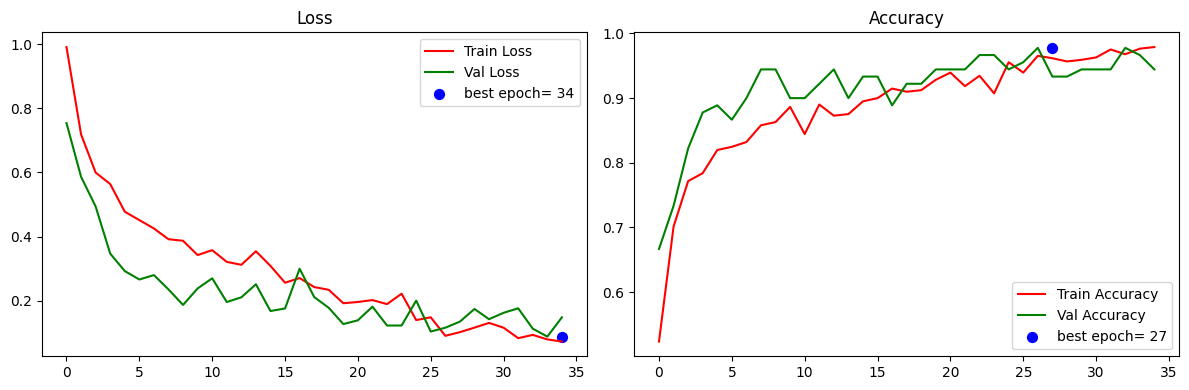

In [38]:
plt.figure(figsize=(12, 4))
plt.style.use('default')

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'r', label='Train Loss')
plt.plot(history.history['val_loss'][:epochs], 'g', label='Val Loss')
plt.scatter(index_loss + 1, val_lowest, 50, 'b',label= loss_label)
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'r', label='Train Accuracy')
plt.plot(history.history['val_accuracy'][:epochs], 'g', label='Val Accuracy')
plt.scatter(index_acc + 1 , acc_highest, 50, 'b', label= acc_label)
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

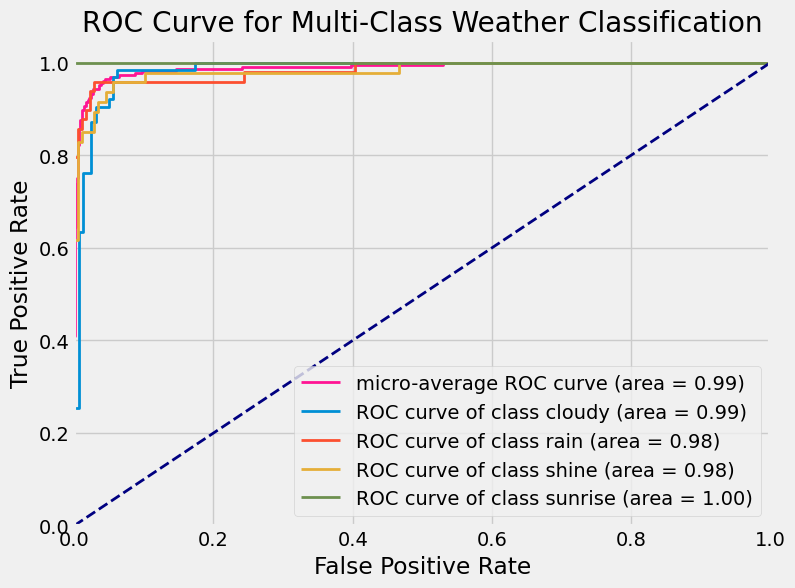

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 6))
plt.style.use('default')
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Weather Classification')
plt.legend(loc="lower right")
plt.show()


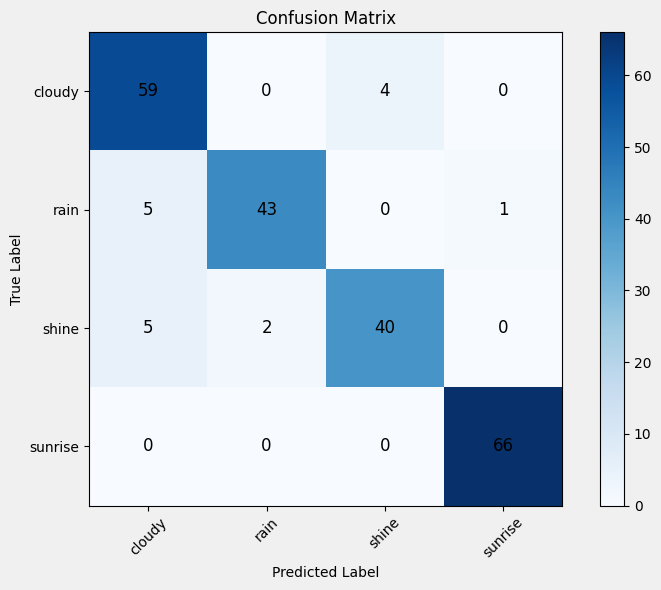

In [35]:
from sklearn.metrics import confusion_matrix

predicted_labels = np.argmax(y_score, axis=1)
conf_matrix = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(8, 6))
plt.style.use('default')
plt.title("Confusion Matrix")
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black', fontsize=12)

plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()